In [10]:
# Load required modules

import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Loading training and test data for arrhythmia Dataset

ECG_Arrhythmia_train_df = pd.read_csv("./MIT_Dataset/mitbih_train.csv", header = None)
ECG_Arrhythmia_test_df = pd.read_csv("./MIT_Dataset/mitbih_test.csv", header = None)

In [4]:
# Creating end to end data pipeline    

from sklearn.utils import resample
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: Load the dataset
def load_dataset(train_file, test_file):
    # Load training dataset
    train_df = pd.read_csv(train_file, header = None)

    # Load test dataset
    test_df = pd.read_csv(test_file, header = None)

    return train_df, test_df

# Step 2: Preprocess the data
def preprocess_data(train_df, test_df):
    
    # Separate input features and target labels for training dataset
    X_train = train_df.iloc[:, 0:187]
    X_train_standardized = StandardScaler().fit_transform(X_train)
    X_train = pd.DataFrame(data=X_train_standardized, columns=X_train.columns)
    y_train = train_df[187]

    # Oversampling dataset to counter class imbalance
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
    # Separate input features and target labels for test dataset
    X_test = test_df.iloc[:, 0:187]
    X_test_standardized = StandardScaler().fit_transform(X_test)
    X_test = pd.DataFrame(data=X_test_standardized, columns=X_test.columns)
    y_test = test_df[187]

    # Split the data into train and validation sets, maintaining the same label distribution
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=50)

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()

    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy()

    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    # Print shapes of datasets
    print("Training data shape - Input Features:", X_train.shape, "Target Labels:", y_train.shape)
    print("Validation data shape - Input Features:", X_val.shape, "Target Labels:", y_val.shape)
    print("Test data shape - Input Features:", X_test.shape, "Target Labels:", y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Step 3: Convert data to PyTorch tensors and create DataLoader objects
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):
    # Preparing data for training
    
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long()
    X_val_tensor = torch.from_numpy(X_val).float()
    y_val_tensor = torch.from_numpy(y_val).long()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long()
    
    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# Step 4: Define main function to execute the pipeline
def data_pipeline(train_file, test_file, batch_size):
    
    # Step 1: Load the dataset
    train_df, test_df = load_dataset(train_file, test_file)

    # Step 2: Preprocess the data
    X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(train_df, test_df)

    # Step 3: Convert data to PyTorch tensors and create DataLoader objects
    train_loader, val_loader, test_loader = create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size)

    return train_loader, val_loader, test_loader

# File paths for training and test datasets
train_file = './MIT_Dataset/mitbih_train.csv'
test_file = './MIT_Dataset/mitbih_test.csv'

# Execute the data processing pipeline
batch_size = 1024
train_loader, val_loader, test_loader = data_pipeline(train_file, test_file, batch_size=batch_size)

Training data shape - Input Features: (253648, 187) Target Labels: (253648,)
Validation data shape - Input Features: (108707, 187) Target Labels: (108707,)
Test data shape - Input Features: (21892, 187) Target Labels: (21892,)


In [6]:
# CNN Resnet Model

import torch
import torch.nn as nn

class ResidualBlockM(nn.Module):
    def __init__(self, filters, kernel_size):
        super(ResidualBlockM, self).__init__()
        self.conv1 = nn.Conv1d(filters, filters, kernel_size, padding='same')
        self.conv2 = nn.Conv1d(filters, filters, kernel_size, padding='same')
        self.activation = nn.ReLU()
        self.max_pooling = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out += residual  # Residual connection
        out = self.activation(out)
        out = self.max_pooling(out)
        return out

class ConvResNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ConvResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_shape[0], 32, 5, padding='same')
        self.activation = nn.ReLU()
        self.residual_blocks = nn.ModuleList([ResidualBlockM(32, 5) for _ in range(5)])
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(192, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        for block in self.residual_blocks:
            x = block(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [7]:
Model = ConvResNet((1, 187), 5).to(device)
print(summary(Model, (1000, 187)))
Model.to('cpu')
Model=None

Layer (type:depth-idx)                   Output Shape              Param #
ConvResNet                               [1000, 5]                 --
├─Conv1d: 1-1                            [1000, 32, 187]           192
├─ModuleList: 1-2                        --                        --
│    └─ResidualBlockM: 2-1               [1000, 32, 94]            --
│    │    └─Conv1d: 3-1                  [1000, 32, 187]           5,152
│    │    └─ReLU: 3-2                    [1000, 32, 187]           --
│    │    └─Conv1d: 3-3                  [1000, 32, 187]           5,152
│    │    └─ReLU: 3-4                    [1000, 32, 187]           --
│    │    └─MaxPool1d: 3-5               [1000, 32, 94]            --
│    └─ResidualBlockM: 2-2               [1000, 32, 47]            --
│    │    └─Conv1d: 3-6                  [1000, 32, 94]            5,152
│    │    └─ReLU: 3-7                    [1000, 32, 94]            --
│    │    └─Conv1d: 3-8                  [1000, 32, 94]            5,152
│ 

In [8]:
# Training with Early Stopping

# Define input shape (assuming each beat is a 1D signal with a certain length)
input_shape = (1, 187)  # Update input_shape accordingly
num_classes = 5  # Change num_classes according to your task

model = ConvResNet(input_shape=input_shape, num_classes=num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

EPOCHS = 1000
best_val_loss = float('inf')
best_model = None
patience = 30
counter = 0 

for epoch in range(EPOCHS):
    
    # Training
    training_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Forward pass
        predictions = model(inputs)
        loss = criterion(predictions, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Training Loss: {training_loss / len(train_loader)}")

    # Validation
    model.eval()
    all_predictions = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predictions = F.softmax(outputs, dim=1)
            predictions = (torch.argmax(predictions, dim=1)).float()
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
    # Calculating average val loss
    avg_val_loss = val_loss / len(val_loader)

    # Calculating averge val acuracy
    all_predictions = torch.tensor(np.concatenate(all_predictions))
    all_labels = torch.tensor(np.concatenate(all_labels))
    avg_val_accuracy = (all_predictions == all_labels).sum().item() / (all_labels == all_labels).sum().item() * 100

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        best_model = model
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping after {epoch+1-patience} epochs with no improvement.")
        break

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Val Loss: {avg_val_loss:.5f}, Val Accuracy: {avg_val_accuracy:.5f}")

print(f"Batch Size: {batch_size}")

Epoch [1/1000], Training Loss: 0.44595562246057296
Epoch [1/1000], Val Loss: 0.24826, Val Accuracy: 90.37504
Epoch [2/1000], Training Loss: 0.17171410993943292
Epoch [2/1000], Val Loss: 0.12340, Val Accuracy: 95.71049
Epoch [3/1000], Training Loss: 0.11359147745515069
Epoch [3/1000], Val Loss: 0.08418, Val Accuracy: 97.23385
Epoch [4/1000], Training Loss: 0.07702991650289585
Epoch [4/1000], Val Loss: 0.10715, Val Accuracy: 95.90183
Epoch [5/1000], Training Loss: 0.06018348928961542
Epoch [5/1000], Val Loss: 0.04979, Val Accuracy: 98.52999
Epoch [6/1000], Training Loss: 0.05014055974841598
Epoch [6/1000], Val Loss: 0.05134, Val Accuracy: 98.34693
Epoch [7/1000], Training Loss: 0.040535353101609696
Epoch [7/1000], Val Loss: 0.04959, Val Accuracy: 98.50424
Epoch [8/1000], Training Loss: 0.03326015199174083
Epoch [8/1000], Val Loss: 0.04630, Val Accuracy: 98.38833
Epoch [9/1000], Training Loss: 0.032065207525456864
Epoch [9/1000], Val Loss: 0.03883, Val Accuracy: 98.72685
Epoch [10/1000], 

In [15]:
# Model Evaluation

def evaluate_model(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_predictions_prob = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            predictions = F.softmax(predictions, dim=1)
            all_predictions_prob.append(predictions.cpu().numpy())
            predictions = (torch.argmax(predictions, dim=1)).long()
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_predictions = torch.tensor(np.concatenate(all_predictions))
    all_predictions_prob = torch.tensor(np.concatenate(all_predictions_prob))
    all_labels = torch.tensor(np.concatenate(all_labels))

    return all_predictions, all_predictions_prob, all_labels

all_predictions, all_predictions_prob, all_labels = evaluate_model(best_model, test_loader, device)

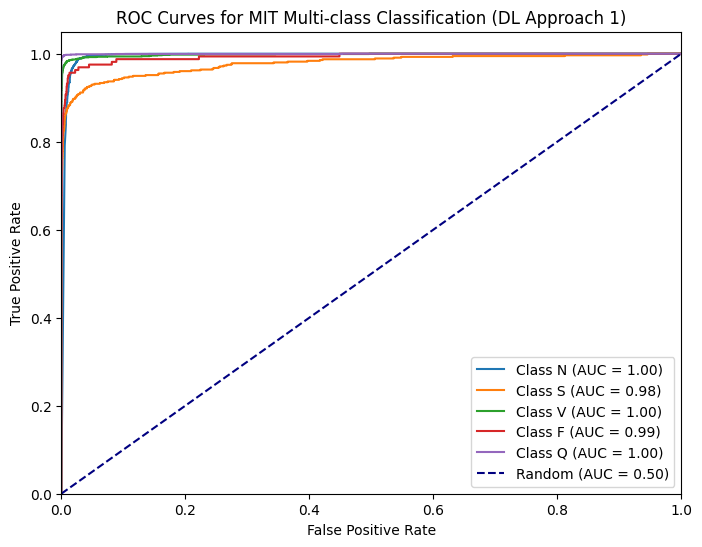

Classification Report Results (DL Approach 1):
              precision    recall  f1-score   support

           N     0.9920    0.9930    0.9925     18118
           S     0.8425    0.8273    0.8348       556
           V     0.9654    0.9641    0.9648      1448
           F     0.8063    0.7963    0.8012       162
           Q     0.9925    0.9900    0.9913      1608

    accuracy                         0.9852     21892
   macro avg     0.9197    0.9142    0.9169     21892
weighted avg     0.9851    0.9852    0.9852     21892

ROC-AUC-OVR Score 0.9951

ROC-AUC-OVO Score 0.9921


In [16]:
# Model Evaluation Results 

# ROC-AUC under the one vs rest setting 
roc_auc_ovr = roc_auc_score(all_labels, all_predictions_prob, average='weighted', multi_class='ovr')

# ROC-AUC under the one vs one setting 
roc_auc_ovo = roc_auc_score(all_labels, all_predictions_prob, average='weighted', multi_class='ovo')

# Covert true labels to one-hot encoded format
all_labels_one_hot = label_binarize(all_labels, classes=np.unique(all_labels))
# Now predictions and true labels are in the same format with dimensions (num_observations, num_classes)

# Plotting ROC curves for every label
class_names = ['N', 'S', 'V', 'F', 'Q']
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(all_labels_one_hot[1])):
    fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], all_predictions_prob[:, i])
    roc_auc[i] = roc_auc_score(all_labels_one_hot[:, i], all_predictions_prob[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(all_labels_one_hot[1])):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for MIT Multi-class Classification (DL Approach 1)')
plt.legend(loc="lower right")
plt.show()

# Calculate validation metrics for entire cross validation results

classification_report_results = classification_report(y_true = all_labels, y_pred = all_predictions, target_names=class_names, digits=4)

print(f"Classification Report Results (DL Approach 1):\n=======================================================\n{classification_report_results}")
print(f"ROC-AUC-OVR Score {roc_auc_ovr:.4f}\n")

print(f"ROC-AUC-OVO Score {roc_auc_ovo:.4f}\n=======================================================")

(5, 5)


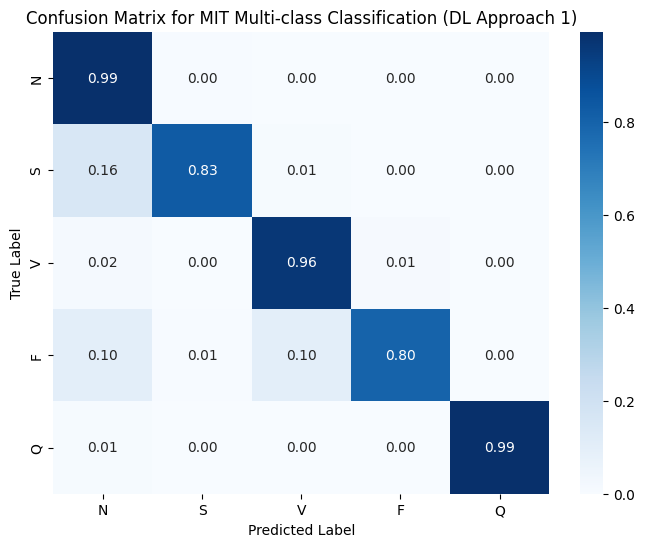

In [17]:
# Plotting confusion matrix

conf_mat = confusion_matrix(y_true=all_labels, y_pred=all_predictions, normalize='true')
print(conf_mat.shape)
fig = plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Adding title and axis labels
plt.title('Confusion Matrix for MIT Multi-class Classification (DL Approach 1)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()